# Example Regression

In this notebook will be showed how to use lit-saint for a regression problem. We will use the "California housing" dataset in which the objective is to predict the Median house value for households within a block (measured in US Dollars)

## Import libraries <a class="anchor" id="import"></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from lit_saint import Saint, SaintConfig, SaintDatamodule, SaintTrainer
from pytorch_lightning import Trainer, seed_everything

## Download Data <a class="anchor" id="download"></a>

In [2]:
df = fetch_california_housing(as_frame=True)

## Configure lit-saint <a class="anchor" id="configure"></a>

In [3]:
# if you want to used default value for the parameters
cfg = SaintConfig()

# otherwise you can use hydra to read a config file (uncomment the following part)
# from hydra.core.config_store import ConfigStore
# cs = ConfigStore.instance()
# cs.store(name="base_config", node=SaintConfig)
# with initialize(config_path="."):
#   cfg = compose(config_name="config")


## Prepare Data <a class="anchor" id="prepare"></a>

In [4]:
seed_everything(42, workers=True)
df = df.frame
df_train, df_test = train_test_split(df, test_size=0.10, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.10, random_state=42)
df_train["split"] = "train"
df_val["split"] = "validation"
df = pd.concat([df_train, df_val])
# The target is in the column MedHouseVal and we can see that it contains some floats so the library will considered the problem as a regression
df.head()

Global seed set to 42


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,split
16907,4.9700,52.0,6.685065,1.120130,800.0,2.597403,37.57,-122.35,5.00001,train
7831,2.8090,20.0,4.305136,1.113293,1855.0,2.802115,33.90,-118.15,1.44600,train
5004,3.3906,48.0,5.732353,0.905882,823.0,2.420588,34.02,-118.32,1.89700,train
8636,7.9614,43.0,5.702517,1.027460,1033.0,2.363844,33.88,-118.41,5.00001,train
11559,4.0194,28.0,5.055031,1.025157,2066.0,3.248428,33.76,-117.98,1.97400,train


## Fit the model <a class="anchor" id="fit"></a>

In [ ]:
data_module = SaintDatamodule(df=df, target="MedHouseVal", split_column="split")
model = Saint(categories=data_module.categorical_dims, continuous=data_module.numerical_columns,
              config=cfg, dim_target=data_module.dim_target)
pretrainer = Trainer(max_epochs=cfg.pretrain.epochs)
trainer = Trainer(max_epochs=10)
saint_trainer = SaintTrainer(pretrainer=pretrainer, trainer=trainer)
saint_trainer.fit(model=model, datamodule=data_module, enable_pretraining=True)

## Make predictions <a class="anchor" id="predict"></a>

In [ ]:
prediction = saint_trainer.predict(model=model, datamodule=data_module, df=df_test)
df_test["prediction"] = prediction

In [7]:
expl_variance = explained_variance_score(df_test["MedHouseVal"], df_test["prediction"])
mae = mean_absolute_error(df_test["MedHouseVal"], df_test["prediction"])
mse = mean_squared_error(df_test["MedHouseVal"], df_test["prediction"])
print(f"Explained Variance: {expl_variance} MAE: {mae} MSE: {mse}")

Explained Variance: 0.6835245941402444 MAE: 0.4766954095214282 MSE: 0.42516899954601584


## Uncertainty Estimation <a class="anchor" id="uncertainty"></a>

In [ ]:
mc_prediction = saint_trainer.predict(model=model, datamodule=data_module, df=df_test, mc_dropout_iterations=4)

In [9]:
mc_prediction

array([[[0.6113666 , 0.5303789 , 0.6088008 , 0.50359756]],

       [[1.6021758 , 1.4766475 , 1.5595936 , 1.6277379 ]],

       [[3.4029758 , 3.4458263 , 3.5525124 , 3.5148988 ]],

       ...,

       [[3.1485445 , 3.0460937 , 3.034754  , 3.1309571 ]],

       [[1.5157897 , 1.4789042 , 1.5377241 , 1.5246242 ]],

       [[1.5674988 , 1.5290661 , 1.4482845 , 1.6628958 ]]], dtype=float32)

array([[<AxesSubplot:title={'center':'variance'}>]], dtype=object)

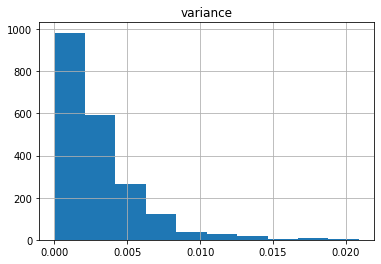

In [10]:
# Given the predictions we can compute the variance across the iterations, so axis=2
var_prediction = np.var(mc_prediction,axis=2)
# Then we focus our attention on the variance of the first class
pd.DataFrame(var_prediction[:,0], columns=["variance"]).hist()